In [1]:
import pyspark
from pyspark.sql import SQLContext
from pyspark.sql.functions import hour, when, col, date_format, to_timestamp
from pyspark.sql.types import DateType
import datetime


In [2]:
sc = pyspark.SparkContext(appName="zf_task")
sqlContext = SQLContext(sc)

/home/vanshil/rrc_env/lib/python3.5/site-packages/pyspark/context.py:225: DeprecationWarning: Support for Python 2 and Python 3 prior to version 3.6 is deprecated as of Spark 3.0. See also the plan for dropping Python 2 support at https://spark.apache.org/news/plan-for-dropping-python-2-support.html.
  DeprecationWarning)


In [3]:
df_telemetry = sqlContext.read.option("header",True).csv("/home/vanshil/Desktop/zf_task/telemetry.csv")
df_failures = sqlContext.read.option("header",True).csv("/home/vanshil/Desktop/zf_task/failures.csv")
df_machines = sqlContext.read.option("header",True).csv("/home/vanshil/Desktop/zf_task/machines.csv")

##### For cleaning telemetry data for cleaning datapoints that are greater than 1st Jan, 2016 00:00:00

In [4]:

df_telemetry_temp = df_telemetry.withColumn("datetime",col("datetime").cast("timestamp"))
y = datetime.datetime(2016,1,1)
df_telemetry_cleaned = df_telemetry_temp.filter(df_telemetry_temp.datetime<y)

In [5]:
df_telemetry_cleaned.show()

+-------------------+---------+----------------+----------------+----------------+----------------+
|           datetime|machineID|            volt|          rotate|        pressure|       vibration|
+-------------------+---------+----------------+----------------+----------------+----------------+
|2015-01-01 06:00:00|        1|151.919998705647|530.813577555042|101.788175260076|49.6040134898504|
|2015-01-01 07:00:00|        1|174.522001096471|535.523532319384|113.256009499254|41.5159054753218|
|2015-01-01 08:00:00|        1|146.912821646066|456.080746005808|107.786964633461|42.0996936545816|
|2015-01-01 09:00:00|        1|179.530560852404|503.469990485512|108.283817221771|37.8477274946112|
|2015-01-01 10:00:00|        1|180.544276621327|371.600611295334| 107.55330679883|41.4678800376109|
|2015-01-01 11:00:00|        1| 141.41175703074|530.857266087542|87.6140012779218|44.9858461978707|
|2015-01-01 12:00:00|        1|184.083821743344|  450.2275288129|87.6973797069792|30.8312627133489|


#### Cleaning failures for duplicates for further outer join 
#### asumpition components columns is not considered

In [6]:


df_failures_cleaned = df_failures.dropDuplicates(subset=['datetime','machineID'])

In [7]:
df_telemetry_cleaned = df_telemetry_cleaned.join(df_failures_cleaned, on=['datetime', 'machineID'], how='outer')

In [8]:
df_telemetry_cleaned.show()

+-------------------+---------+----------------+----------------+----------------+----------------+-------+
|           datetime|machineID|            volt|          rotate|        pressure|       vibration|failure|
+-------------------+---------+----------------+----------------+----------------+----------------+-------+
|2015-01-01 06:00:00|      476|212.367979092572| 319.66678839637|110.670611578006|36.5460214527218|   null|
|2015-01-01 06:00:00|      760|184.542329839681|442.486992935241| 96.289440949018|33.4353596105716|   null|
|2015-01-01 06:00:00|      922|157.548916779885| 454.03150909256|103.659771993094|36.4184136615947|   null|
|2015-01-01 07:00:00|      122|148.871723297714|346.941338239024|100.072716634435|47.0817014997421|   null|
|2015-01-01 07:00:00|      366|192.210850412861|427.670080625141|107.107089384777|48.3824271272506|   null|
|2015-01-01 07:00:00|      430|155.649055939255|432.857553152784|111.851293039026|34.3856330003791|   null|
|2015-01-01 07:00:00|      4

In [9]:
df_telemetry_cleaned = df_telemetry_cleaned.join(df_machines, on=['machineID'], how='outer')

#### wherever failure is null there the column is marked zero and otherwise it is marked 1 . further helpful for generating labels

In [10]:


df_telemetry_labeled = df_telemetry_cleaned.withColumn("failure",when(col("failure").isNotNull(),'1').otherwise('0'))

In [11]:
df_telemetry_labeled.show()

+---------+-------------------+----------------+----------------+----------------+----------------+-------+------+---+
|machineID|           datetime|            volt|          rotate|        pressure|       vibration|failure| model|age|
+---------+-------------------+----------------+----------------+----------------+----------------+-------+------+---+
|      296|2015-01-09 03:00:00|171.302523315541|478.161032557448| 96.186255065758|32.9160861743769|      0|model1|  5|
|      296|2015-01-23 06:00:00|167.523400545631|515.064197650393|106.391024193625|41.6073098354008|      0|model1|  5|
|      296|2015-01-24 00:00:00|180.397228104738|524.872142428439|102.871534752792|42.0092719627669|      0|model1|  5|
|      296|2015-01-24 10:00:00|180.122314795148|459.234959284642|112.824618325131|46.1331985231815|      0|model1|  5|
|      296|2015-01-31 14:00:00|151.478558067995|454.186658088772|102.132114187536|  41.23899424475|      0|model1|  5|
|      296|2015-01-31 21:00:00|161.691490644465|

In [ ]:
df_telemetry_labeled.coalesce(1).write.option("header", "true").csv("features_unclean.csv")

In [ ]:
## feature engineering and visualisations

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
df_features = pd.read_csv("/home/vanshil/Desktop/zf_task/features.csv")

In [14]:
df_features.head()

,machineID,datetime,volt,rotate,pressure,vibration,failure,model,age
0,296,2015-01-02 22:00:00,195.644993,397.161609,117.534915,43.068444,0,model1,5
1,296,2015-01-13 08:00:00,167.231340,437.992356,107.735910,29.958309,0,model1,5
2,296,2015-01-26 22:00:00,155.494618,444.586288,92.871857,46.600535,0,model1,5
3,296,2015-01-27 04:00:00,163.568941,533.025381,102.996083,33.197771,0,model1,5
4,296,2015-03-07 20:00:00,163.491264,521.007650,81.429920,42.889361,0,model1,5


#### Plotting a correlation matrix for a random machineID to see whether volt, pressure ,rotate and vibration are independent

In [ ]:
n = random.randint(0,1000)
df_analyse=df_features[df_features['machineID']==n]

In [ ]:
df_analyse.drop(columns=['machineID','datetime','model','age'],inplace=True)

In [ ]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df_analyse.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

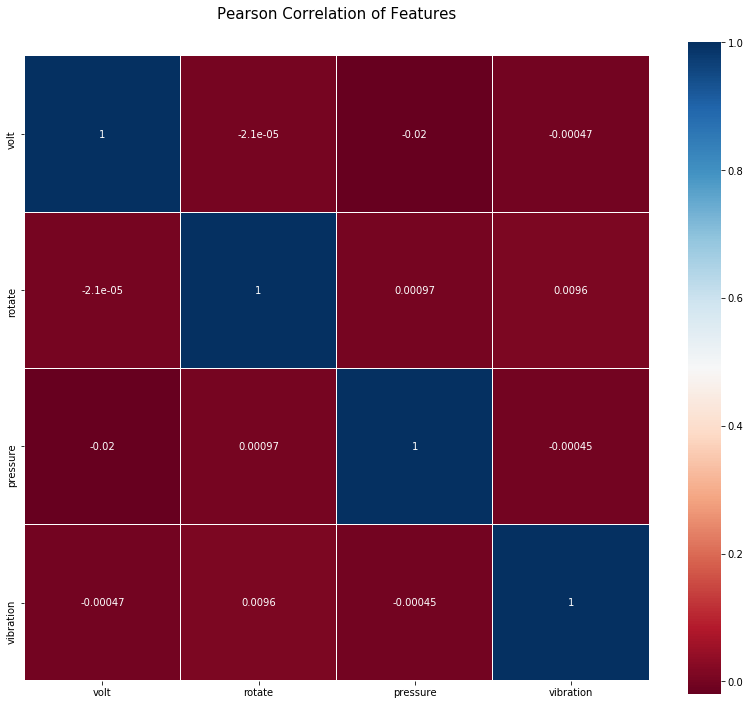

#### Visual inspection for failure cases w.r.t to volt, pressure, vibraion and rotate

#### for predictive maintainance and  i am assuming a window of 5 hours and marking 5 rows before a failure as failure

In [4]:
idx=np.where(df_features.failure.values==1)[0]

indices=[]
from tqdm.notebook import tqdm
for x in tqdm(idx):
    for i in range(0,6): ## the window I chose
        if(df_features.iloc[x,0]==df_features.iloc[(x-i),0]): ## getting the indices and checking whether they belong to the same machine Id as our data of telemetry has all machineId's together
                indices.append(x-i)



In [5]:
print(indices, len(indices)) ##these are the indices where we have to mark failures

[2271, 2270, 2269, 2268, 2267, 2266, 3613, 3612, 3611, 3610, 3609, 3608, 3918, 3917, 3916, 3915, 3914, 3913, 4087, 4086, 4085, 4084, 4083, 4082, 4376, 4375, 4374, 4373, 4372, 4371, 6949, 6948, 6947, 6946, 6945, 6944, 7004, 7003, 7002, 7001, 7000, 6999, 7184, 7183, 7182, 7181, 7180, 7179, 7368, 7367, 7366, 7365, 7364, 7363, 7870, 7869, 7868, 7867, 7866, 7865, 8536, 8535, 8534, 8533, 8532, 8531, 9935, 9934, 9933, 9932, 9931, 9930, 10211, 10210, 10209, 10208, 10207, 10206, 12111, 12110, 12109, 12108, 12107, 12106, 13714, 13713, 13712, 13711, 13710, 13709, 13790, 13789, 13788, 13787, 13786, 13785, 14210, 14209, 14208, 14207, 14206, 14205, 14478, 14477, 14476, 14475, 14474, 14473, 16901, 16900, 16899, 16898, 16897, 16896, 23546, 23545, 23544, 23543, 23542, 23541, 23810, 23809, 23808, 23807, 23806, 23805, 24824, 24823, 24822, 24821, 24820, 24819, 26811, 26810, 26809, 26808, 26807, 26806, 29541, 29540, 29539, 29538, 29537, 29536, 30797, 30796, 30795, 30794, 30793, 30792, 33452, 33451, 33450, 

In [13]:
arr=np.zeros((df_features.shape[0]))
arr[indices]=1
df_features['failure']=arr

In [14]:
np.sum(df_features['failure']==1) ## no of total cases considered as failures

38144

In [16]:
df_features.drop(columns=['failures'],inplace=True)

In [9]:
## now converting model to one-hot encoding

from sklearn.preprocessing import LabelEncoder
# creating initial dataframe
model_types = ('model1', 'model2' , 'model3' , 'model4')
model_df = pd.DataFrame(model_types, columns=['model'])
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
model_df['model_cat'] = labelencoder.fit_transform(model_df['model'])
model_df

,model,model_cat
0,model1,0
1,model2,1
2,model3,2
3,model4,3


In [10]:
from sklearn.preprocessing import OneHotEncoder
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')

enc_df = pd.DataFrame(enc.fit_transform(model_df[['model_cat']]).toarray())

model_df = model_df.join(enc_df)
model_df

,model,model_cat,0,1,2,3
0,model1,0,1.0,0.0,0.0,0.0
1,model2,1,0.0,1.0,0.0,0.0
2,model3,2,0.0,0.0,1.0,0.0
3,model4,3,0.0,0.0,0.0,1.0


In [17]:
df_features_edited=pd.merge(df_features, model_df, how='outer', on=['model']) ## doing an outer join to place the one-hot encodng at respective places

In [18]:
df_features_edited.head()

,machineID,datetime,volt,rotate,pressure,vibration,failure,model,age,model_cat,0,1,2,3
0,296,2015-01-02 22:00:00,195.644993,397.161609,117.534915,43.068444,0.0,model1,5,0,1.0,0.0,0.0,0.0
1,296,2015-01-13 08:00:00,167.231340,437.992356,107.735910,29.958309,0.0,model1,5,0,1.0,0.0,0.0,0.0
2,296,2015-01-26 22:00:00,155.494618,444.586288,92.871857,46.600535,0.0,model1,5,0,1.0,0.0,0.0,0.0
3,296,2015-01-27 04:00:00,163.568941,533.025381,102.996083,33.197771,0.0,model1,5,0,1.0,0.0,0.0,0.0
4,296,2015-03-07 20:00:00,163.491264,521.007650,81.429920,42.889361,0.0,model1,5,0,1.0,0.0,0.0,0.0


In [19]:
df_features_edited.drop(columns=['datetime','model_cat','model'],inplace=True)

In [22]:
df_features_edited.head()

,machineID,volt,rotate,pressure,vibration,failure,age,0,1,2,3
0,296,195.644993,397.161609,117.534915,43.068444,0.0,5,1.0,0.0,0.0,0.0
1,296,167.231340,437.992356,107.735910,29.958309,0.0,5,1.0,0.0,0.0,0.0
2,296,155.494618,444.586288,92.871857,46.600535,0.0,5,1.0,0.0,0.0,0.0
3,296,163.568941,533.025381,102.996083,33.197771,0.0,5,1.0,0.0,0.0,0.0
4,296,163.491264,521.007650,81.429920,42.889361,0.0,5,1.0,0.0,0.0,0.0


In [23]:
## making training and testing dataset

In [24]:
from sklearn.model_selection import train_test_split
df_unhealthy = df_features_edited[df_features_edited['failure']==1]
df_healthy  = df_features_edited[df_features_edited['failure']==0]

In [25]:
df_unhealthy.shape

(38144, 11)

In [26]:
df_healthy.shape

(8715856, 11)

In [27]:
##highly skewed dataset

In [28]:
##Splitting the training and testing dataset in 80:20

x_train_healthy,x_test_healthy = train_test_split(df_healthy,test_size = 0.2)
x_train_unhealthy,x_test_unhealthy = train_test_split(df_unhealthy,test_size = 0.2)

x_train = pd.concat([x_train_healthy,x_train_unhealthy])
x_test = pd.concat([x_test_healthy,x_test_unhealthy])

x_train.reset_index(drop=True,inplace=True)
x_test.reset_index(drop=True,inplace=True)

In [29]:
x_train.head()

,machineID,volt,rotate,pressure,vibration,failure,age,0,1,2,3
0,769,180.727156,394.928535,108.986320,39.098950,0.0,4,1.0,0.0,0.0,0.0
1,148,155.150840,422.120804,94.790002,49.637434,0.0,9,0.0,0.0,1.0,0.0
2,488,175.672546,435.277850,92.399260,41.230263,0.0,6,0.0,0.0,1.0,0.0
3,256,178.726020,375.535064,91.367185,45.580307,0.0,9,0.0,0.0,0.0,1.0
4,640,161.486360,439.087827,87.927400,39.288666,0.0,13,0.0,1.0,0.0,0.0


In [30]:
x_test.head()

,machineID,volt,rotate,pressure,vibration,failure,age,0,1,2,3
0,761,179.740325,494.155334,115.532464,42.616557,0.0,20,0.0,0.0,1.0,0.0
1,99,151.836927,565.253393,123.897350,46.448609,0.0,14,0.0,1.0,0.0,0.0
2,165,190.628262,443.676702,99.128140,39.562085,0.0,19,0.0,0.0,0.0,1.0
3,708,181.347802,470.302929,101.582462,42.303743,0.0,7,0.0,0.0,0.0,1.0
4,888,166.905430,470.097708,100.340858,37.168305,0.0,20,0.0,0.0,1.0,0.0


In [31]:
##labels for training

y_train = x_train['failure']
y_test = x_test['failure']


In [34]:
y_train.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: failure, dtype: float64

In [35]:
x_train.drop(columns=['machineID','failure'],inplace=True)
x_test.drop(columns=['machineID','failure'],inplace=True)

In [36]:
x_train.head()

,volt,rotate,pressure,vibration,age,0,1,2,3
0,180.727156,394.928535,108.986320,39.098950,4,1.0,0.0,0.0,0.0
1,155.150840,422.120804,94.790002,49.637434,9,0.0,0.0,1.0,0.0
2,175.672546,435.277850,92.399260,41.230263,6,0.0,0.0,1.0,0.0
3,178.726020,375.535064,91.367185,45.580307,9,0.0,0.0,0.0,1.0
4,161.486360,439.087827,87.927400,39.288666,13,0.0,1.0,0.0,0.0


In [37]:
x_test.head()

,volt,rotate,pressure,vibration,age,0,1,2,3
0,179.740325,494.155334,115.532464,42.616557,20,0.0,0.0,1.0,0.0
1,151.836927,565.253393,123.897350,46.448609,14,0.0,1.0,0.0,0.0
2,190.628262,443.676702,99.128140,39.562085,19,0.0,0.0,0.0,1.0
3,181.347802,470.302929,101.582462,42.303743,7,0.0,0.0,0.0,1.0
4,166.905430,470.097708,100.340858,37.168305,20,0.0,0.0,1.0,0.0


In [ ]:
### Models with handling of class imbalance
##logisitc regression with weighted class


In [ ]:
from sklearn.linear_model import LogisticRegression

w = {0:1, 1:99}
logreg = LogisticRegression(class_weight=w)
logreg.fit(df_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score
round(accuracy_score(y_test, logreg.predict(df_test))*100,2)

The accuracy is 99.15, But we know this is skewed then accuracy metric wouldnt show the true performane
Considering failures important I would take recall as metric to compare model performances over accuracy


In [ ]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, logreg.predict(df_test)).ravel()

In [ ]:
tn, fp, fn, tp

(1735880, 7292, 7558, 71)

In [ ]:
recall=tp/(tp+fn)

0.009306593262550794


In [ ]:
## trying to check whether naive boosting would work as it inherently tries to handle class imbalance

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(x_train,y_train)

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, xgb.predict(x_test)).ravel()

In [ ]:
tn, fp, fn, tp

(1743172, 0, 7629, 0)


The poor performance shows naive boosting is unable to handle this class imbalance

In [38]:

## Taking approach of under sampling the dataset
## Undersampling is done on the healthy dataset with the unhealthy cases remaining the same

In [39]:
df_healthy_subset = df_healthy.sample(n=38200)
df_healthy_subset.reset_index(drop=True,inplace=True)

In [40]:

x_train_healthy_subset,x_test_healthy_subset = train_test_split(df_healthy_subset,test_size = 0.2)
x_train_unhealthy_subset,x_test_unhealthy_subset = train_test_split(df_unhealthy,test_size = 0.2) 

In [41]:
x_train_healthy_subset.reset_index(drop=True,inplace=True)
x_test_healthy_subset.reset_index(drop=True,inplace=True)

x_train_unhealthy_subset.reset_index(drop=True,inplace=True)
x_test_unhealthy_subset.reset_index(drop=True,inplace=True)

In [42]:
x_train_subset=pd.concat([x_train_healthy_subset,x_train_unhealthy_subset])
x_test_subset=pd.concat([x_test_healthy_subset,x_test_unhealthy_subset])

In [43]:
x_train_subset.reset_index(drop=True,inplace=True)

In [44]:
x_train_subset.head()

,machineID,volt,rotate,pressure,vibration,failure,age,0,1,2,3
0,641,169.595355,390.977679,85.371493,29.807633,0.0,9,0.0,0.0,1.0,0.0
1,136,164.697133,474.355445,97.384681,33.436772,0.0,11,0.0,0.0,1.0,0.0
2,259,157.257257,373.314575,88.869766,36.075001,0.0,8,0.0,0.0,1.0,0.0
3,617,151.041388,383.234352,83.516180,43.393044,0.0,14,0.0,1.0,0.0,0.0
4,632,156.841043,507.804172,99.083632,32.417093,0.0,8,0.0,1.0,0.0,0.0


In [45]:
x_train_subset.shape

(61075, 11)

In [47]:
x_test_subset.reset_index(drop=True,inplace=True)
x_test_subset.head()

,machineID,volt,rotate,pressure,vibration,failure,age,0,1,2,3
0,764,143.906335,468.233509,99.866817,37.608680,0.0,8,0.0,0.0,1.0,0.0
1,66,206.872265,448.289144,103.426319,31.780175,0.0,6,0.0,1.0,0.0,0.0
2,181,137.393744,466.236396,98.539343,42.328205,0.0,10,0.0,0.0,0.0,1.0
3,2,167.244461,479.334619,83.126963,34.307092,0.0,7,0.0,0.0,0.0,1.0
4,40,179.347966,386.500977,95.603090,32.770006,0.0,4,0.0,0.0,1.0,0.0


In [49]:
x_test_subset.shape

(15269, 11)

In [50]:
y_train_subset=x_train_subset['failure']
y_test_subset=x_test_subset['failure']


In [51]:
x_test_subset.drop(columns=['machineID','failure'],inplace=True)
x_train_subset.drop(columns=['machineID','failure'],inplace=True)

In [ ]:
####Models
## Naive Logistic Regression


logreg = LogisticRegression()
logreg.fit(x_train_subset, y_train_subset)

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test_subset, logreg.predict(x_test_subset)).ravel()

In [ ]:
tn, fp, fn, tp

(4430, 3210, 3358, 4271)

In [ ]:
recall = tp/(tp+fn)

0.5598374623148512

confiusion matrix

In [ ]:
from sklearn.metrics import plot_confusion_matrix
class_names=['healthy' ,'unhealthy']
plot_confusion_matrix(logreg, x_test_subset, y_test_subset,normalize='true',cmap=plt.cm.Blues,display_labels=class_names)  

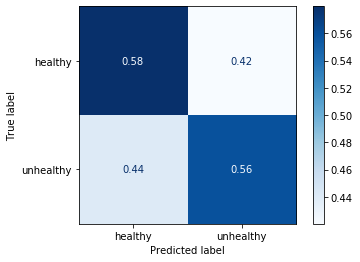



Positive coefficients increase the log-odds of the response (and thus increase the probability), and negative coefficients decrease the log-odds of the response (and thus decrease the probability).

In [ ]:

coeff_df = pd.DataFrame(x_train.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df


In [ ]:

coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

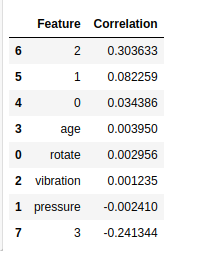

In [ ]:
#svm

In [ ]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(x_train_subset, y_train_subset)
y_pred = svc.predict(x_test_subset)

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test_subset, y_pred).ravel()

In [ ]:
tn, fp, fn, tp

(3914, 3726, 3207, 4422)

In [ ]:
recall = tp/(tp+fn)

0.5796303578450649

In [ ]:
plot_confusion_matrix(svc, x_test_subset, y_test_subset,normalize='true',cmap=plt.cm.Blues,display_labels=class_names)  

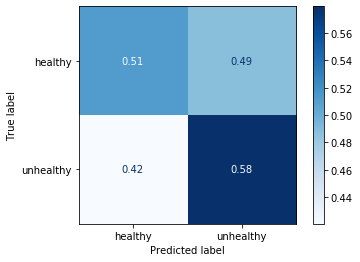

Boosting

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(x_train_subset,y_train_subset)


In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test_subset, xgb.predict(x_test_subset)).ravel()


In [ ]:
tn, fp, fn, tp

(4390, 3250, 3356, 4273)


In [ ]:
recall = tp/(tp+fn)

0.5600996198715428

In [ ]:
plot_confusion_matrix(xgb, x_test_subset, y_test_subset,normalize='true',cmap=plt.cm.Blues,display_labels=class_names)  

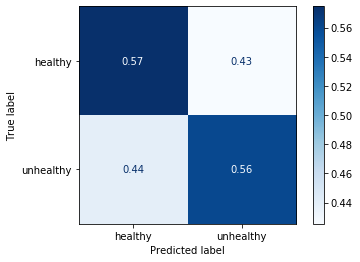

In [ ]:
#### Futurework

#### Exploring how to leverage time series for deep learning techniques like LSTM. Further to enhance performance this could be posed as anomaly detection problem in a semi supervised setting/unsupervised